# Parce que le 2 devenait trop gros

In [1]:
import numpy as np
import pandas as pd
import gstlearn as gl
import gstlearn.plot as gp
import gstlearn.document as gdoc
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import pyproj
gdoc.setNoScroll()

data = r'data\pfas_2023_surf_ground_drink.parquet'

<IPython.core.display.Javascript object>

In [2]:
df_num_surf_france = pd.read_parquet(data)
df_db = df_num_surf_france[['lat','lon','pfas_sum']]

dat = gl.Db_fromPanda(df_db)
dat.setLocators(["lon","lat"], gl.ELoc.X)
dat.setLocator("pfas_sum", gl.ELoc.Z)
varioParamOmni = gl.VarioParam.createOmniDirection(npas=70, dpas=0.005, toldis=0.2)
varioexp = gl.Vario(varioParamOmni)
err = varioexp.compute(dat)

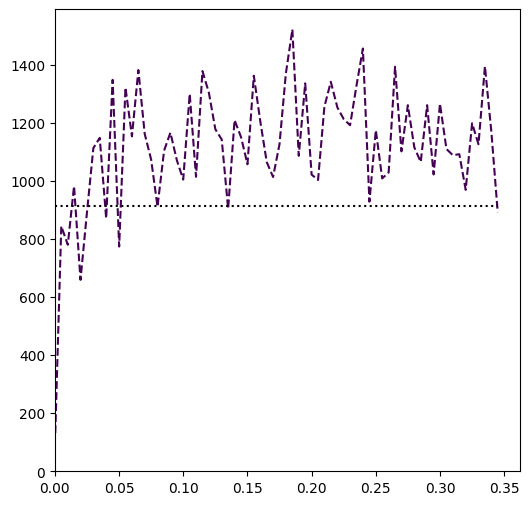

In [3]:
gp.setDefault(dims=[6,6])
gp.varmod(varioexp)
plt.show()

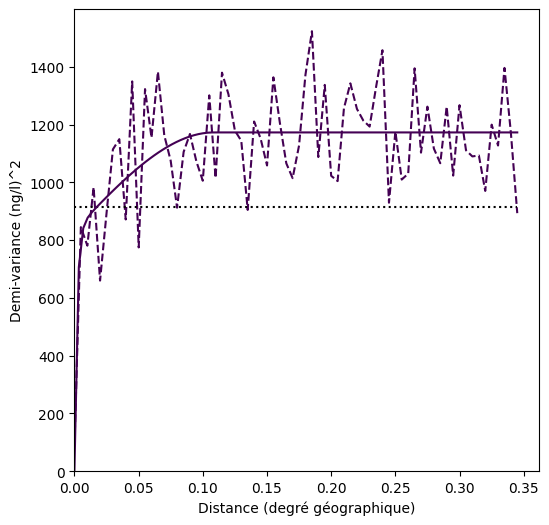

In [32]:
fitmod = gl.Model()
types = [gl.ECov.NUGGET, gl.ECov.EXPONENTIAL ,gl.ECov.SPHERICAL]
err = fitmod.fit(varioexp, types=types)

gp.varmod(varioexp, fitmod)
plt.xlabel('Distance (degré géographique)')
plt.ylabel('Demi-variance (ng/l)^2')
plt.show()

In [31]:
fitmod


Model characteristics
Space dimension              = 2
Number of variable(s)        = 1
Number of basic structure(s) = 2
Number of drift function(s)  = 0
Number of drift equation(s)  = 0

Covariance Part
---------------
Exponential
- Sill         =    833.547
- Range        =      0.006
- Theo. Range  =      0.002
Spherical
- Sill         =    339.059
- Range        =      0.109
Total Sill     =   1172.606
Known Mean(s)     0.000

In [5]:
grid = gl.DbGrid.create(x0=[-5.5,41],dx=[0.1,0.1],nx=[160,110])

In [6]:
dbfmt = gl.DbStringFormat.createFromFlags(flag_extend=True)
grid.display(dbfmt)


Data Base Grid Characteristics

Data Base Summary
-----------------
File is organized as a regular grid
Space dimension              = 2
Number of Columns            = 3
Total number of samples      = 17600

Grid characteristics:
---------------------
Origin :     -5.500    41.000
Mesh   :      0.100     0.100
Number :        160       110

Data Base Extension
-------------------
Coor #1 - Min =     -5.500 - Max =     10.400 - Ext = 15.9
Coor #2 - Min =     41.000 - Max =     51.900 - Ext = 10.9

Variables
---------
Column = 0 - Name = rank - Locator = NA
Column = 1 - Name = x1 - Locator = x1
Column = 2 - Name = x2 - Locator = x2


In [7]:
uniqueNeigh = gl.NeighUnique.create()

In [8]:
# Krigeage simple

err = gl.kriging(dbin=dat, dbout=grid, model=fitmod, 
              neigh=uniqueNeigh,
              flag_est=True, flag_std=True, flag_varz=False,
              namconv=gl.NamingConvention("SK")
              )

In [9]:
# Krigeage ordinaire

fitmodOK = fitmod.clone()
err = fitmodOK.addDrift(gl.DriftM())

err = gl.kriging(dbin=dat, dbout=grid, model=fitmodOK, 
              neigh=uniqueNeigh,
              flag_est=True, flag_std=True, flag_varz=False,
              namconv=gl.NamingConvention("OK")
              )

In [10]:
# Krigeage ordinaire avec moyenne mobile

lessSmallNeigh = gl.NeighMoving.create(radius=0.5, nmini=5) # 1°~80km ici 40km quintuple de la portée du variogramme
err = gl.kriging(dbin=dat, dbout=grid, model=fitmodOK, neigh=lessSmallNeigh,
              flag_est=True, flag_std=True, 
              namconv=gl.NamingConvention("lessSmall"))

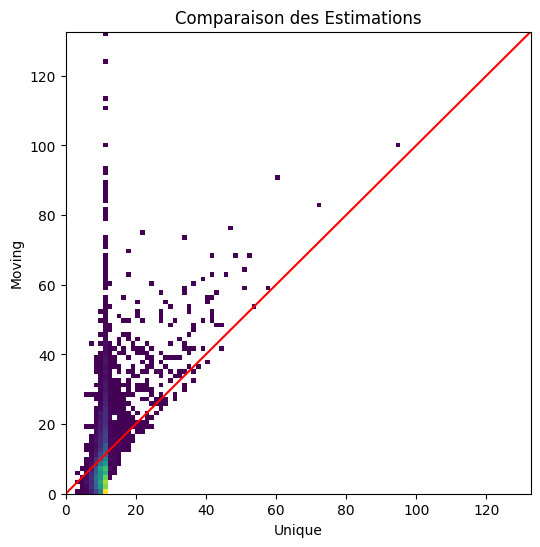

In [11]:
ax = gp.correlation(grid,namex = "OK*estim",namey="lessSmall*estim", 
                    bins=100, bissLine=True, flagSameAxes=True, cmin=1)
ax.decoration(title="Comparaison des Estimations", xlabel="Unique", ylabel="Moving")

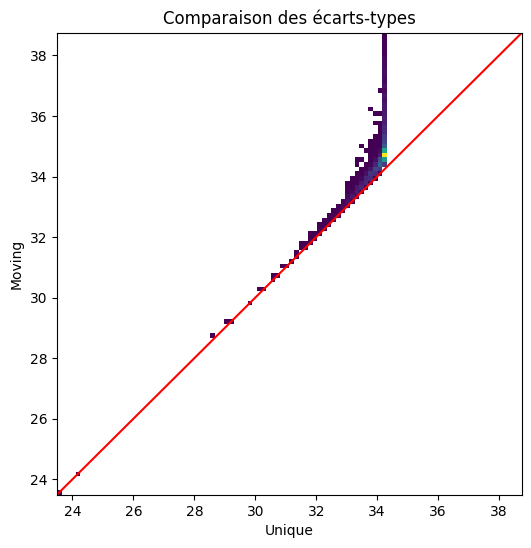

In [12]:
ax = gp.correlation(grid,namex = "OK*stdev",namey="lessSmall*stdev", 
                    bins=100, bissLine=True, flagSameAxes=True, cmin=1)
ax.decoration(title="Comparaison des écarts-types", xlabel="Unique", ylabel="Moving")

# Krigeage universel

In [13]:
polDriftModel = gl.Model.create()
err = polDriftModel.setDriftIRF(order=1)

vario_res2dir = gl.Vario(varioParamOmni)
err = vario_res2dir.compute(dat,model=polDriftModel)

In [14]:
varioparam = gl.VarioParam.createMultiple(ndir=2, npas=70, dpas=0.005)
vario_raw2dir = gl.Vario(varioparam)
err = vario_raw2dir.compute(dat)

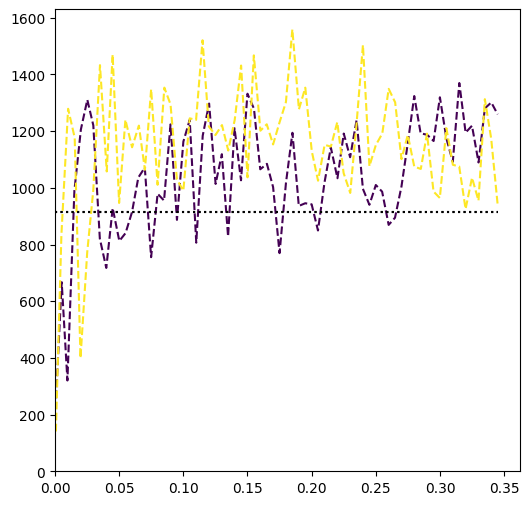

In [15]:
ax = gp.varmod(vario_raw2dir)

In [16]:
err = polDriftModel.fit(vario_res2dir,types=[gl.ECov.NUGGET, gl.ECov.EXPONENTIAL, gl.ECov.CUBIC])

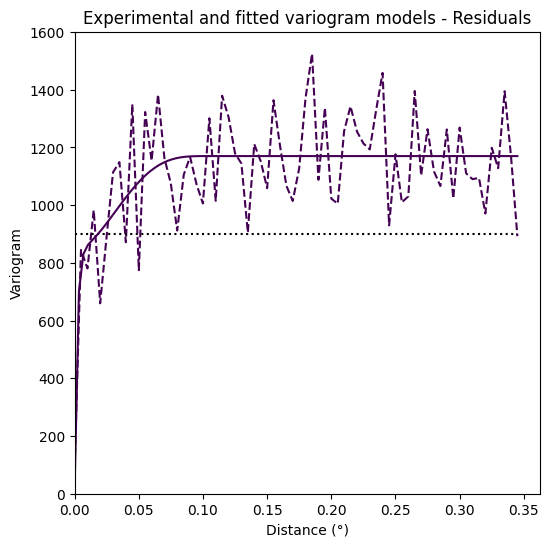

In [17]:
ax = gp.varmod(vario_res2dir, polDriftModel)
ax.decoration(title="Experimental and fitted variogram models - Residuals", 
              xlabel = "Distance (°)", ylabel = "Variogram")

In [18]:
regResults = gl.regression(dat, nameResp="pfas_sum", mode=2, model=polDriftModel)
regResults.display()


Linear Regression
-----------------
- Calculated on 4120 active values
- Explanatory Variable #1 = 55.7642
- Explanatory Variable #2 = 1.08827
- Explanatory Variable #3 = -0.98717
- Initial variance        = 915.238
- Variance of residuals   = 901.69


In [19]:
err = gl.kriging(dbin=dat, dbout=grid, model=polDriftModel, 
              neigh=uniqueNeigh,
              namconv=gl.NamingConvention.create(prefix="UK"))

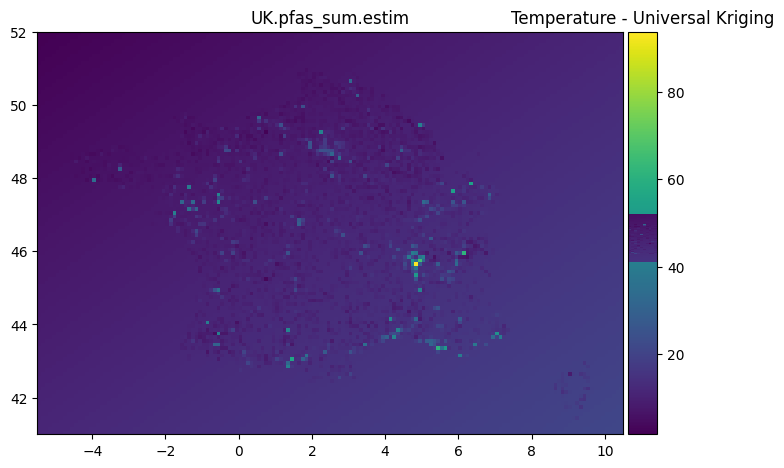

In [27]:
gp.setDefaultGeographic(dims=[8,8])
fig, ax = gp.initGeographic()
ax.raster(grid, flagLegend=True)

ax = grid.plot(nameRaster="UK*estim")
# ax = dat.plot(flagCst=True, color="black")
ax.decoration(title="Temperature - Universal Kriging")

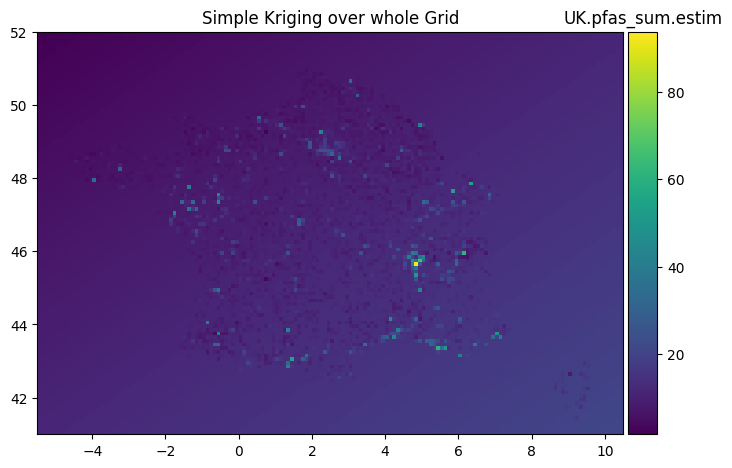

In [33]:


fig, ax = gp.initGeographic()
ax.raster(grid, flagLegend=True)
# ax.symbol(dat, c='black', alpha=0.03)
ax.decoration(title="Simple Kriging over whole Grid")
plt.show()

In [34]:
varioParamOmni = gl.VarioParam.createOmniDirection(100)
grid_pfas = gl.db_vcloud(dat, varioParamOmni)
grid_pfas.display()


Data Base Grid Characteristics

Data Base Summary
-----------------
File is organized as a regular grid
Space dimension              = 2
Number of Columns            = 4
Total number of samples      = 10000

Grid characteristics:
---------------------
Origin :      0.000     0.000
Mesh   :      0.171    27.464
Number :        100       100

Variables
---------
Column = 0 - Name = rank - Locator = NA
Column = 1 - Name = x1 - Locator = x1
Column = 2 - Name = x2 - Locator = x2
Column = 3 - Name = Cloud.pfas_sum - Locator = NA


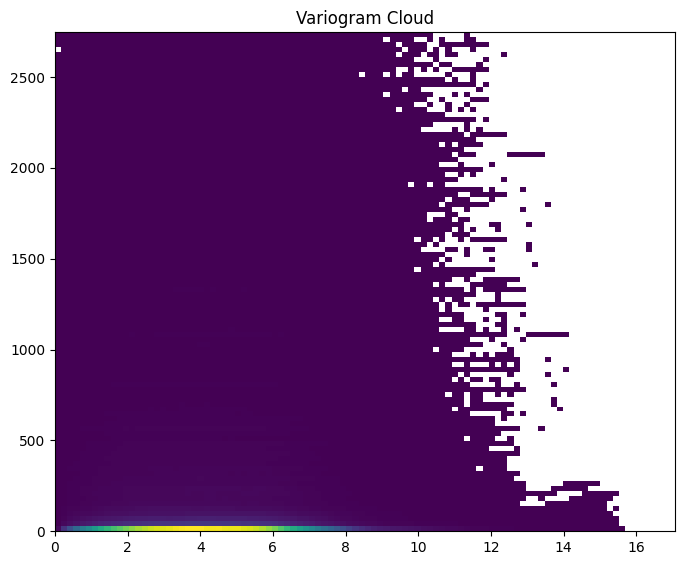

In [36]:
ax = grid_pfas.plot("Cloud.pfas_sum")
plt.gca().set_aspect('0.005')
ax.decoration(title="Variogram Cloud")